#  Tutorial 4: Bitwise Demapper
November 11, 2021

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

### Problem 4.2 - Optimality of Binary NN Demapper for AWGN

Consider an additive white Gaussian noise (AWGN) channel
$$Y = X + Z $$
with binary phase shift keying (BPSK) input $X$ uniformly distributed on $\{-1, 1 \}$, Gaussian
noise $Z\sim\mathcal{N} (0, \sigma^2)$. Assume the binary label $B = b(X)$ with $b(-1) = 0$ and $b(1) = 1$.
1. Show that
$$L = log\frac{P_{B|Y}(1|y)}{P_{B|Y}(0|y)}$$
is given by
$$ L= \lambda y$$

2. For $\text{SNR} = [0, 1,\dots, 5]$ train the binary NN demapper in Figure 4.3. Compare
the weight $w$ after training with the value of $\lambda$ that you calculated in 1.

In [ ]:
def mapper(msg, alphabet): # maps message a in [0,1,..,M-1] to alphabet symbols
    return alphabet[msg]

def awgn_channel(x, snr, seed=None): # returns Y = X+Z
    rng = np.random.Generator(np.random.PCG64(seed))
    power_x = np.mean(np.abs(x) ** 2)
    noise_power = power_x / snr
    noise = np.sqrt(noise_power) * rng.normal(size=x.shape)
    return x + noise

In [ ]:
M = 2 # cardinality of the alphabet
a = np.random.choice(M, 10000) # messages
x = mapper(a, np.array([ -1., 1.])) # symbols

In [ ]:
class bin_demapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1,1, bias=False)

    def forward(self, y):
        return self.h1(y)

In [ ]:
SNRdBs = np.array([0,1,2,3,4,5])
SNRs = 10**(SNRdBs/10)
# Preallocate
weigths = np.zeros(SNRs.size)
logits = np.zeros((SNRs.size,10000))
ys = np.zeros((SNRs.size,10000))

# Convert labels to torch tensor
a_t = torch.Tensor(a.reshape((-1,1)))
# Loss function
# Your code here
loss_fn = nn.BCEWithLogitsLoss()

for idx,snr in enumerate(SNRs):
    print(f'--- SNR is: {snr:.2f} ---')
    # Generate y
    y = awgn_channel(x, snr)
    ys[idx,:] = y
    # Convert data
    y_t = torch.Tensor(y.reshape(-1,1))
    # Initialize network
    bin_demap = bin_demapper()
    # Optimizer
    optimizer = optim.Adam(bin_demap.parameters(), lr=0.1)
    for j in range(1000):
        l = bin_demap(y_t)
        loss = loss_fn(l, a_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # Printout and visualization
        if j % 50 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')

    weigths[idx]=bin_demap.h1.weight[0].detach().numpy()[0]
    logits[idx,:] = l.detach().numpy().reshape((-1,))



--- SNR is: 1.00 ---
epoch 0: Loss = 0.4486
epoch 50: Loss = 0.3529
epoch 100: Loss = 0.3529
epoch 150: Loss = 0.3529
epoch 200: Loss = 0.3529
epoch 250: Loss = 0.3529
epoch 300: Loss = 0.3529
epoch 350: Loss = 0.3529
epoch 400: Loss = 0.3529
epoch 450: Loss = 0.3529
epoch 500: Loss = 0.3529
epoch 550: Loss = 0.3529
epoch 600: Loss = 0.3529
epoch 650: Loss = 0.3529
epoch 700: Loss = 0.3529
epoch 750: Loss = 0.3529
epoch 800: Loss = 0.3529
epoch 850: Loss = 0.3529
epoch 900: Loss = 0.3529
epoch 950: Loss = 0.3529
--- SNR is: 1.26 ---
epoch 0: Loss = 0.9518
epoch 50: Loss = 0.3113
epoch 100: Loss = 0.3101
epoch 150: Loss = 0.3101
epoch 200: Loss = 0.3101
epoch 250: Loss = 0.3101
epoch 300: Loss = 0.3101
epoch 350: Loss = 0.3101
epoch 400: Loss = 0.3101
epoch 450: Loss = 0.3101
epoch 500: Loss = 0.3101
epoch 550: Loss = 0.3101
epoch 600: Loss = 0.3101
epoch 650: Loss = 0.3101
epoch 700: Loss = 0.3101
epoch 750: Loss = 0.3101
epoch 800: Loss = 0.3101
epoch 850: Loss = 0.3101
epoch 900: Los

Expected values for lambda : [2.         2.51785082 3.16978638 3.99052463 5.02377286 6.32455532]
Value of w after the training : [2.03814054 2.45223045 3.08241153 3.97062159 5.36668777 6.09298229] 
Slopes of the plots : [2.0381405  2.45223046 3.0824114  3.97062164 5.36668782 6.09273964]


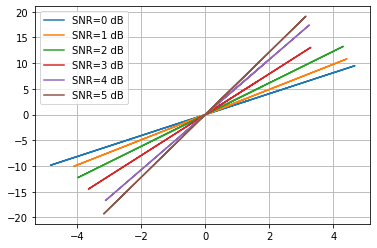

In [ ]:
for j in range(SNRs.size):
    plt.plot(ys[j,:], logits[j,:], label=f'SNR={SNRdBs[j]} dB')
plt.grid()
plt.legend()
print(f'Expected values for lambda : {2/(1/SNRs)}')
print(f'Value of w after the training : {weigths} ')
print(f'Slopes of the plots : {(logits[:,0]/ys[:,0])}')


### Problem 4.3 - Function composition
Use the function compositions developed in Section 4.4 to plot Figure 4.7.

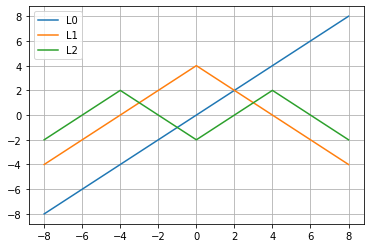

In [ ]:
y = np.arange(-8,9,1)
# Your code here
l0 = y
l1 = -np.abs(l0)+4
l2 = -np.abs(l1)+2
plt.plot(y, l0, label = 'L0')
plt.plot(y,l1, label = 'L1')
plt.plot(y,l2, label = 'L2')
plt.grid()
plt.legend()
plt.show()

### Problem 4.4 - ReLU activation
Design an NN using linear neurons and ReLU activation that for input $y$ outputs $a \cdot |y| + b$.

In [ ]:
class relu_nn(nn.Module):
    def __init__(self, a, b):
        super().__init__()
        self.h1 = nn.Linear(1,2, bias=False)
        self.act = nn.ReLU()
        self.h1.weight = nn.Parameter(torch.Tensor([[a],[-a]]))
        self.out = nn.Linear(2,1)
        self.out.bias = nn.Parameter(torch.Tensor([b]))
        self.out.weight = nn.Parameter(torch.Tensor([1., 1.]))

    def forward(self, y):
        y = self.out(self.act(self.h1(y)))
        return y

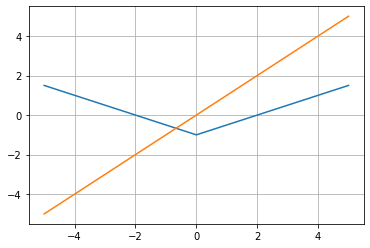

In [ ]:
# Plot of the expected output
y = np.arange(-5.,6.)
a= 0.5
b = -1.
plt.plot(y, a*np.abs(y)+b)
plt.plot(y,y)
plt.grid()

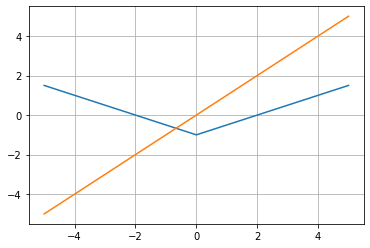

In [ ]:
# Plot of the NN output
y_t = torch.tensor(y.reshape(-1,1,1))
net = relu_nn(a,b)
net = net.float()
z = net(y_t.float()).detach().numpy()
plt.plot(y,z)
plt.plot(y,y)
plt.grid()

### Problem 4.5 - Bitwise NN demapper
Consider the Gray labeled channel input alphabet
$$\begin{matrix}
\text{symbol} & -3 &-1 &1 &3\\
\text{label} &00 &01 &11 &10
\end{matrix}$$
1. For $\text{SNR} = [5, 6,\dots, 10]$ train the bitwise NN demapper from Figure 4.6.

In [ ]:
def get_gray_labeling(msg):
    label = np.array([[0,0], [0,1], [1,1], [1,0]])
    return label[msg, :]

In [ ]:
# Create data
M = 4 # cardinality of the alphabet
m = 2 # number of bits per symbol
a = np.random.choice(M,10000) # messages
x = mapper(a, np.array([ -3., -1., 1., 3.])) # symbols
bits = get_gray_labeling(a)
print(bits.shape)

(10000, 2)


In [ ]:
# Define the network
class BitwiseNNDemapper(torch.nn.Module):
    def __init__(self, num_bitlevels):
        super().__init__()
        self.num_bitlevels = num_bitlevels

        # Output neurons
        self.param = []
        self.lin_out = []

        for j in range(self.num_bitlevels):
            lin_out = nn.Linear(1, 1, bias=False)
            lin_out.weight = nn.Parameter(torch.Tensor([[1.]]))  # trainable output weight: adjust level of confidence via w
            self.param = self.param + list(lin_out.parameters()) # prepare a list of parameters to be passed to an optimizer
            self.lin_out.append(lin_out)

        # Intermediate neurons
        self.lin = []
        for j in range(1, num_bitlevels):
            linj = nn.Linear(1, 1)
            linj.weight = nn.Parameter(torch.Tensor([[-1.]]), requires_grad=False)
            linj.bias = nn.Parameter(torch.tensor([2.**(num_bitlevels - j)])) # trainable bias: adjust transitions through zero. May not be
                                                                              # exactly in the middle of two neighboring nodes, in particular
                                                                              # in the case of low SNR
            self.param = self.param + list(linj.parameters()) # prepare a list of parameters to be passed to an optimizer
            self.lin.append(linj)

    def forward(self, y):
        out = []
        out.append(self.lin_out[0](y))

        for j in range(1, self.num_bitlevels):
            y = torch.abs(y)
            y = self.lin[j - 1](y)
            out.append(self.lin_out[j](y))

        return torch.cat(out, 1)

    def parameters(self):
        return self.param

In [ ]:
SNRdBs = np.array([5,6,7,8,9,10])
SNRs = 10**(SNRdBs/10)
b_t = torch.Tensor(bits)
# Loss function
loss_fn = nn.BCEWithLogitsLoss()
# Preallocate
equivocations_bw = np.zeros(SNRs.size) #bit-wise equivocations
for idx,snr in enumerate(SNRs):
    print(f'--- SNR is: {snr:.2f} ---')
    y = awgn_channel(x, snr)
    y_t = torch.Tensor(y.reshape(-1,1))
    # Initialize network
    demap = BitwiseNNDemapper(num_bitlevels=m)
    # Optimizer
    optimizer = optim.Adam(demap.parameters(), lr=0.005)
    for j in range(1000):
        l = demap(y_t)
        loss = loss_fn(l, b_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Printout and visualization
        if j % 50 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')
    equivocations_bw[idx]= (2*loss)/np.log(2)

--- SNR is: 3.16 ---
epoch 0: Loss = 0.3758
epoch 50: Loss = 0.3631
epoch 100: Loss = 0.3598
epoch 150: Loss = 0.3589
epoch 200: Loss = 0.3587
epoch 250: Loss = 0.3586
epoch 300: Loss = 0.3586
epoch 350: Loss = 0.3586
epoch 400: Loss = 0.3586
epoch 450: Loss = 0.3586
epoch 500: Loss = 0.3586
epoch 550: Loss = 0.3586
epoch 600: Loss = 0.3586
epoch 650: Loss = 0.3586
epoch 700: Loss = 0.3586
epoch 750: Loss = 0.3586
epoch 800: Loss = 0.3586
epoch 850: Loss = 0.3586
epoch 900: Loss = 0.3586
epoch 950: Loss = 0.3586
--- SNR is: 3.98 ---
epoch 0: Loss = 0.3500
epoch 50: Loss = 0.3301
epoch 100: Loss = 0.3215
epoch 150: Loss = 0.3179
epoch 200: Loss = 0.3163
epoch 250: Loss = 0.3156
epoch 300: Loss = 0.3153
epoch 350: Loss = 0.3152
epoch 400: Loss = 0.3151
epoch 450: Loss = 0.3151
epoch 500: Loss = 0.3151
epoch 550: Loss = 0.3151
epoch 600: Loss = 0.3151
epoch 650: Loss = 0.3151
epoch 700: Loss = 0.3151
epoch 750: Loss = 0.3151
epoch 800: Loss = 0.3151
epoch 850: Loss = 0.3151
epoch 900: Los

2. Plot the log probabilities $\ell_0(y)$ and $\ell_1(y)$ output by the trained NN demapper for $y \in [-4,4]$.

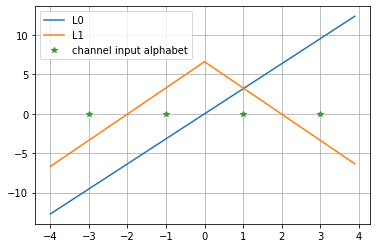

In [ ]:
y = np.arange(-4,4,0.1)
ll = demap(torch.tensor(y.reshape(-1,1)).float()).detach().numpy()
plt.plot(y,ll[:,0],label='L0')
plt.plot(y,ll[:,1],label='L1')
plt.plot(np.array([-3.,-1.,1.,3.]), np.zeros(4), linestyle='', marker='*', label='channel input alphabet')
plt.legend()
plt.grid()


3. For the trained NN demapper, estimate the sum of the bitwise equivocations.
$$H(B_0|Y) + H(B_1|Y) $$
How does it compare to the equivocation achieved by the symbolwise NN demapper
from Problem 3.2?

In [ ]:
class awgn_demapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.out = nn.Linear(1, 4)

    def forward(self, y):
        y = self.out(y)
        return y

In [ ]:
# Code from Tutorial 3
# Prepare data
a_t = torch.Tensor(a.reshape(-1,))
a_t = a_t.type(torch.LongTensor)
# Loss function
loss_fn = nn.CrossEntropyLoss()
# Trainings loop
equivocations_sw = np.zeros(SNRs.size) #symbol-wise equivocation
for idx,snr in enumerate(SNRs):
    print(f'---- SNR is: {snr:.2f}')
    y = awgn_channel(x, snr)
    y_t = torch.Tensor(y.reshape(-1, 1))
    # Initialize network
    demap = awgn_demapper()
    # Optimizer
    optimizer = optim.Adam(demap.parameters(), lr=0.05)
    for j in range(1000):
        logit = demap(y_t).reshape(-1, 4)
        loss = loss_fn(logit, a_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Printout and visualization
        if j % 50 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')
    equivocations_sw[idx] = loss / np.log(2)

---- SNR is: 3.16
epoch 0: Loss = 1.2847
epoch 50: Loss = 0.7271
epoch 100: Loss = 0.7164
epoch 150: Loss = 0.7160
epoch 200: Loss = 0.7159
epoch 250: Loss = 0.7159
epoch 300: Loss = 0.7159
epoch 350: Loss = 0.7159
epoch 400: Loss = 0.7159
epoch 450: Loss = 0.7159
epoch 500: Loss = 0.7159
epoch 550: Loss = 0.7159
epoch 600: Loss = 0.7159
epoch 650: Loss = 0.7159
epoch 700: Loss = 0.7159
epoch 750: Loss = 0.7159
epoch 800: Loss = 0.7159
epoch 850: Loss = 0.7159
epoch 900: Loss = 0.7159
epoch 950: Loss = 0.7159
---- SNR is: 3.98
epoch 0: Loss = 1.3298
epoch 50: Loss = 0.6614
epoch 100: Loss = 0.6312
epoch 150: Loss = 0.6268
epoch 200: Loss = 0.6260
epoch 250: Loss = 0.6259
epoch 300: Loss = 0.6259
epoch 350: Loss = 0.6259
epoch 400: Loss = 0.6259
epoch 450: Loss = 0.6259
epoch 500: Loss = 0.6259
epoch 550: Loss = 0.6259
epoch 600: Loss = 0.6259
epoch 650: Loss = 0.6259
epoch 700: Loss = 0.6259
epoch 750: Loss = 0.6259
epoch 800: Loss = 0.6259
epoch 850: Loss = 0.6259
epoch 900: Loss = 0.

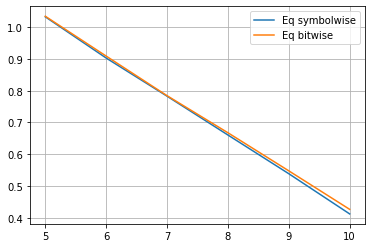

In [ ]:
plt.plot(SNRdBs, equivocations_sw, label='Eq symbolwise')
plt.plot(SNRdBs, equivocations_bw, label='Eq bitwise')
plt.legend()
plt.grid()